# Music Recommendation System with Spotify Data
### 1. Loading Data :


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

file_path = 'data/spotify_data.csv'
df_raw = pd.read_csv(file_path)

print("Original data shape:", df_raw.shape)
print("Original data head:\n", df_raw.head())

Original data shape: (1159764, 20)
Original data head:
    Unnamed: 0    artist_name        track_name                track_id  \
0           0     Jason Mraz   I Won't Give Up  53QF56cjZA9RTuuMZDrSA6   
1           1     Jason Mraz  93 Million Miles  1s8tP3jP4GZcyHDsjvw218   
2           2  Joshua Hyslop  Do Not Let Me Go  7BRCa8MPiyuvr2VU3O9W0F   
3           3   Boyce Avenue          Fast Car  63wsZUhUZLlh1OsyrZq7sz   
4           4   Andrew Belle  Sky's Still Blue  6nXIYClvJAfi6ujLiKqEq8   

   popularity  year     genre  danceability  energy  key  loudness  mode  \
0          68  2012  acoustic         0.483   0.303    4   -10.058     1   
1          50  2012  acoustic         0.572   0.454    3   -10.286     1   
2          57  2012  acoustic         0.409   0.234    3   -13.711     1   
3          58  2012  acoustic         0.392   0.251   10    -9.845     1   
4          54  2012  acoustic         0.430   0.791    6    -5.419     0   

   speechiness  acousticness  instrumental

### 2. Initial Cleaning & Preprocessing :

In [13]:
print("Missing values before dropping:\n", df_raw.isnull().sum())
df_clean = df_raw.dropna().copy() # Use .copy() to avoid SettingWithCopyWarning
print("\nShape before dropping NA:", df_raw.shape)
print("\nShape after dropping NA:", df_clean.shape)


# Checking for duplicates
print("\nDuplicate rows:", df_clean.duplicated().sum())

Missing values before dropping:
 Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

Shape before dropping NA: (1159764, 20)

Shape after dropping NA: (1159748, 20)

Duplicate rows: 0


### 3. Feature Selection and Overview

The dataset contains various audio features from Spotify. For our similarity model, we'll focus on intrinsic audio characteristics rather than metadata.

**Selected Features for Modeling:**

| **Feature** | **Description** | **Range** |
| :---------- | :-------------- | :-------- |
| **Danceability** | Suitability for dancing based on rhythm and beat | 0.0-1.0 |
| **Energy** | Intensity and activity level | 0.0-1.0 |
| **Key** | Musical key (requires one-hot encoding) | -1 to 11 |
| **Loudness** | Overall loudness (requires scaling) | -60 to 0 dB |
| **Mode** | Major (1) or Minor (0) key (requires one-hot encoding) | 0 or 1 |
| **Speechiness** | Presence of spoken words | 0.0-1.0 |
| **Acousticness** | Likelihood of being acoustic | 0.0-1.0 |
| **Instrumentalness** | Likelihood of having no vocals | 0.0-1.0 |
| **Liveness** | Presence of audience/live recording | 0.0-1.0 |
| **Valence** | Musical positiveness/mood | 0.0-1.0 |
| **Tempo** | Speed in BPM (requires scaling) | Varies |

We exclude metadata (artist_name, track_name, track_id, genre, year), popularity, duration_ms, and time_signature as they're less relevant for audio similarity.

In [14]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

df = df_clean[features]
print("\nSelected features shape:", df.shape)

# Set the index to track_id from the original dataframe
df.index = df_clean['track_id'].values
df.index.name = 'track_id'


Selected features shape: (1159748, 11)


### 4. Feature Engineering & Transformation:

In [15]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd 

# Apply min-max scaling to tempo 
print("\nTempo statistics before scaling:")
print(df['tempo'].describe())
scaler_tempo = MinMaxScaler()
df['tempo'] = scaler_tempo.fit_transform(df[['tempo']])
print("\nTempo statistics after scaling:")
print(df['tempo'].describe())

# One-hot encode key
key_dummies = pd.get_dummies(df['key'], prefix='key', drop_first=False) # Keep all keys
df = pd.concat([df, key_dummies], axis=1)

# One-hot encode mode
mode_dummies = pd.get_dummies(df['mode'], prefix='mode', drop_first=False) # Keep both 0 and 1
df = pd.concat([df, mode_dummies], axis=1)

# Drop original categorical columns
df.drop(['key', 'mode'], axis=1, inplace=True)

print("\nProcessed features head (after OHE):\n", df.head())
print("Processed features shape (after OHE):", df.shape)
print("Index check:", df.index.name)

# Create some music-specific Meaningful composite features
df['energy_to_acousticness_ratio'] = df['energy'] / (df['acousticness'] + 0.01)
df['vocal_character'] = df['speechiness'] * (1 - df['instrumentalness'])


Tempo statistics before scaling:
count    1.159748e+06
mean     1.213775e+02
std      2.977964e+01
min      0.000000e+00
25%      9.879800e+01
50%      1.219310e+02
75%      1.399030e+02
max      2.499930e+02
Name: tempo, dtype: float64

Tempo statistics after scaling:
count    1.159748e+06
mean     4.855236e-01
std      1.191219e-01
min      0.000000e+00
25%      3.952031e-01
50%      4.877377e-01
75%      5.596277e-01
max      1.000000e+00
Name: tempo, dtype: float64


/var/folders/93/lcr499bs33s3sbz5nld5dwvc0000gn/T/ipykernel_919/3461003564.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tempo'] = scaler_tempo.fit_transform(df[['tempo']])



Processed features head (after OHE):
                         danceability  energy  loudness  speechiness  \
track_id                                                              
53QF56cjZA9RTuuMZDrSA6         0.483   0.303   -10.058       0.0429   
1s8tP3jP4GZcyHDsjvw218         0.572   0.454   -10.286       0.0258   
7BRCa8MPiyuvr2VU3O9W0F         0.409   0.234   -13.711       0.0323   
63wsZUhUZLlh1OsyrZq7sz         0.392   0.251    -9.845       0.0363   
6nXIYClvJAfi6ujLiKqEq8         0.430   0.791    -5.419       0.0302   

                        acousticness  instrumentalness  liveness  valence  \
track_id                                                                    
53QF56cjZA9RTuuMZDrSA6        0.6940          0.000000    0.1150    0.139   
1s8tP3jP4GZcyHDsjvw218        0.4770          0.000014    0.0974    0.515   
7BRCa8MPiyuvr2VU3O9W0F        0.3380          0.000050    0.0895    0.145   
63wsZUhUZLlh1OsyrZq7sz        0.8070          0.000000    0.0797    0.508   
6

### 5. Exploratory Data Analysis :


Calculating Correlation Matrix...


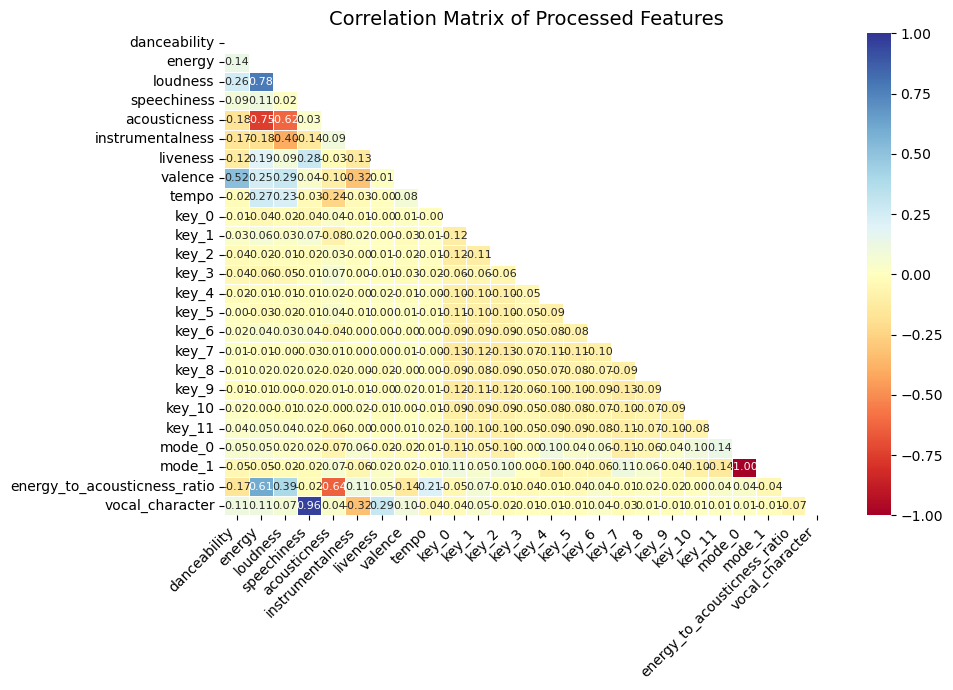

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\nCalculating Correlation Matrix...")
correlation_matrix = df.corr()

plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, mask=mask, annot_kws={"size": 8})
plt.title('Correlation Matrix of Processed Features', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Correlation Analysis Findings

The correlation matrix reveals several highly correlated feature pairs:

| Feature Pair | Correlation Coefficient |
|--------------|-------------------------|
| energy and loudness | 0.781 |
| energy and acousticness | -0.753 |
| speechiness and vocal_character | 0.965 |
| mode_0 and mode_1 | -1.000 |

These strong correlations suggest potential redundancy in our feature set, which may impact model performance.   
The perfect negative correlation between mode_0 and mode_1 is expected since they are one-hot encoded from the same categorical variable.

In [17]:

# Drop highly correlated features to reduce redundancy
print("\nDropping highly correlated features...")
features_to_drop = ['mode_1', 'vocal_character', 'acousticness', 'loudness']
df = df.drop(columns=features_to_drop)

print(f"Features dropped: {features_to_drop}")
print(f"Remaining features: {df.columns.tolist()}")
print("Original dataframe shape:", df_raw.shape)
print(f"New dataframe shape: {df.shape}")


Dropping highly correlated features...
Features dropped: ['mode_1', 'vocal_character', 'acousticness', 'loudness']
Remaining features: ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_0', 'energy_to_acousticness_ratio']
Original dataframe shape: (1159764, 20)
New dataframe shape: (1159748, 21)


#### Feature Importance Analysis


Evaluating feature importance using Random Forest...


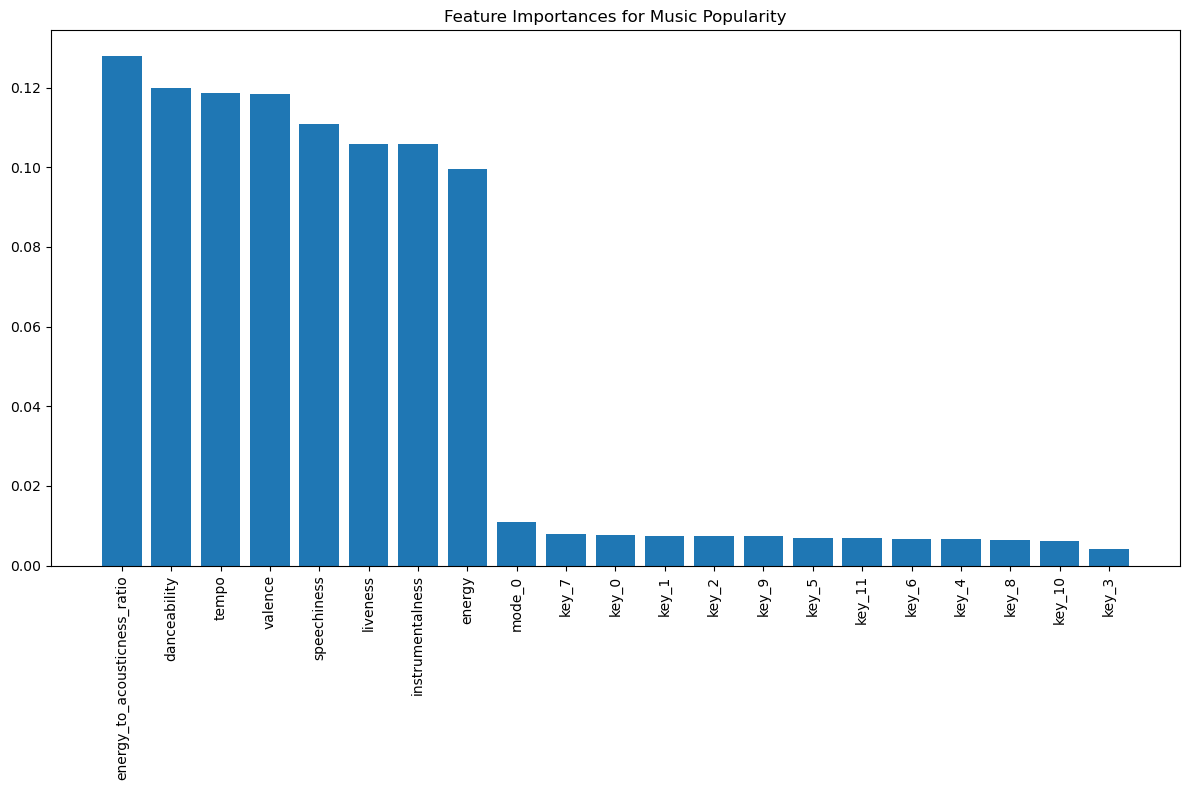

Features with importance > 0.05: ['energy_to_acousticness_ratio', 'danceability', 'tempo', 'valence', 'speechiness', 'liveness', 'instrumentalness', 'energy']
Refined feature set shape: (1159748, 8)


In [18]:
print("\nEvaluating feature importance using Random Forest...")
from sklearn.ensemble import RandomForestRegressor
import multiprocessing

# Use a simple target like popularity
target = df_clean['popularity']  

# Train a random forest model to get feature importance with parallel processing
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(df, target)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances for Music Popularity')
plt.bar(range(df.shape[1]), importances[indices], align='center')
plt.xticks(range(df.shape[1]), [df.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Keep only top features
importance_threshold = 0.05  # This will capture the most significant features based on your graph
important_indices = [i for i, imp in enumerate(importances) if imp > importance_threshold]
top_features = [df.columns[i] for i in indices if importances[i] > importance_threshold]
print(f"Features with importance > {importance_threshold}: {top_features}")
df_important = df[top_features]

# Let's also keep the custom ratio features since they're highly important
if 'energy_to_acousticness_ratio' not in df_important.columns and 'energy_to_acousticness_ratio' in df.columns:
    df_important['energy_to_acousticness_ratio'] = df['energy_to_acousticness_ratio']

if 'vocal_character' not in df_important.columns and 'vocal_character' in df.columns:
    df_important['vocal_character'] = df['vocal_character']

print(f"Refined feature set shape: {df_important.shape}")

Improved music-specific components (first 5 rows):
                        energy_to_acousticness_ratio  danceability     tempo  \
track_id                                                                       
53QF56cjZA9RTuuMZDrSA6                      0.430398         0.483  0.533639   
1s8tP3jP4GZcyHDsjvw218                      0.932238         0.572  0.560744   
7BRCa8MPiyuvr2VU3O9W0F                      0.672414         0.409  0.559344   
63wsZUhUZLlh1OsyrZq7sz                      0.307222         0.392  0.819867   
6nXIYClvJAfi6ujLiKqEq8                      9.576271         0.430  0.687475   

                        valence  speechiness  liveness  instrumentalness  \
track_id                                                                   
53QF56cjZA9RTuuMZDrSA6    0.139       0.0429    0.1150          0.000000   
1s8tP3jP4GZcyHDsjvw218    0.515       0.0258    0.0974          0.000014   
7BRCa8MPiyuvr2VU3O9W0F    0.145       0.0323    0.0895          0.000050   
63wsZUhU

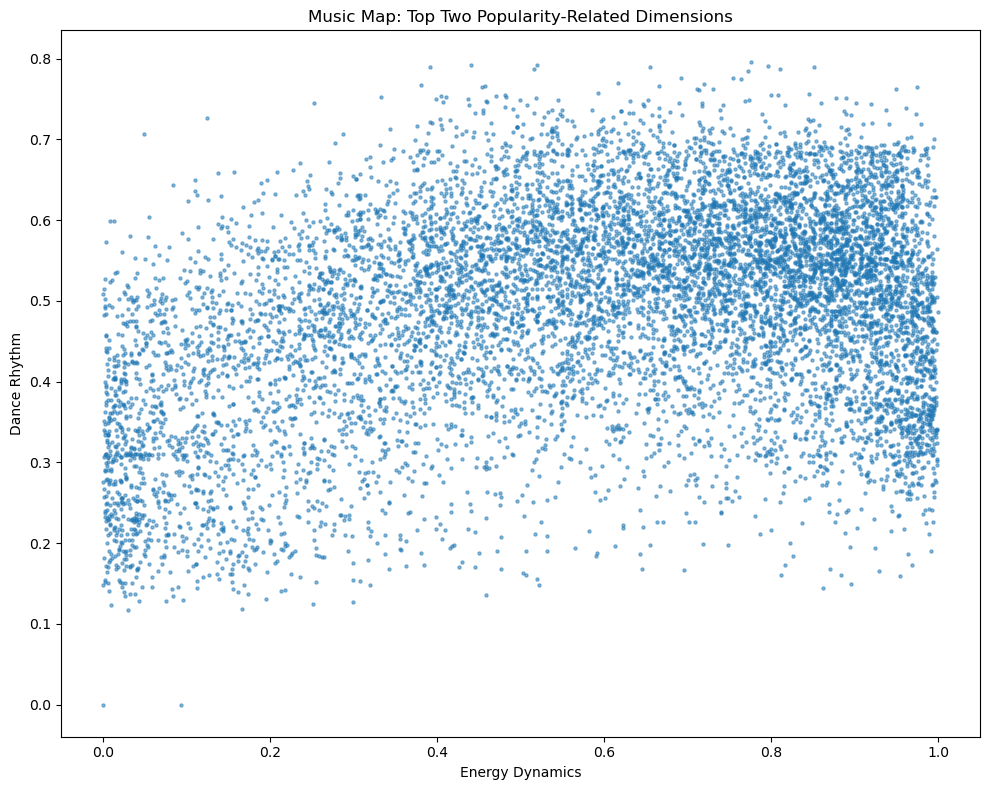

In [24]:
# Define more musically meaningful components based on feature importance
df_important.loc[:, 'energy_dynamics'] = df['energy'] 
df_important.loc[:, 'dance_rhythm'] = 0.6*df['danceability'] + 0.4*df['tempo']
df_important.loc[:, 'emotional_content'] = df['valence']
df_important.loc[:, 'vocal_presence'] = df['speechiness'] - 0.5*df['instrumentalness']
df_important.loc[:, 'performance_style'] = df['liveness']

print("Improved music-specific components (first 5 rows):")
print(df_important.head())

# Visualize top dimensions
plt.figure(figsize=(10, 8))
sample_size = min(10000, len(df_important))
plt.scatter(
    df_important['energy_dynamics'].iloc[:sample_size], 
    df_important['dance_rhythm'].iloc[:sample_size],
    alpha=0.5, s=5
)
plt.xlabel('Energy Dynamics')
plt.ylabel('Dance Rhythm')
plt.title('Music Map: Top Two Popularity-Related Dimensions')
plt.tight_layout()
plt.show()

### 6. Standard Scaling:
We'll initially scale all features to have zero mean and unit variance. This is important for distance-based algorithms like K-Means and PCA..

In [21]:
# Import StandardScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Apply standard scaling to the reduced feature set
scaler_opt = StandardScaler()
df_important_scaled = scaler_opt.fit_transform(df_important)
df_important_scaled = pd.DataFrame(df_important_scaled, index=df.index, columns=df_important.columns)

### 7. Dimensionality Reduction:
We'll use PCA on the scaled data to reduce the number of features while retaining most of the information (variance).

In [27]:
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA with 6 components
n_components = 6
pca = PCA(n_components=n_components)
df_pca_improved = pca.fit_transform(df_important_scaled)
df_pca_improved = pd.DataFrame(df_pca_improved, 
                           index=df.index, 
                           columns=[f'PC{i+1}' for i in range(n_components)])

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Using {n_components} components for dimensionality reduction")
print(f"Total explained variance: {cumulative_variance[-1]:.4f}")
print("Explained variance by component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} - Cumulative: {cumulative_variance[i]:.4f}")

print("\nPCA data shape:", df_pca_improved.shape)
print("First 5 rows of PCA-transformed data:")
df_pca_improved.head()

Using 6 components for dimensionality reduction
Total explained variance: 0.9199
Explained variance by component:
PC1: 0.2905 - Cumulative: 0.2905
PC2: 0.2045 - Cumulative: 0.4950
PC3: 0.1717 - Cumulative: 0.6668
PC4: 0.1028 - Cumulative: 0.7695
PC5: 0.0806 - Cumulative: 0.8501
PC6: 0.0697 - Cumulative: 0.9199

PCA data shape: (1159748, 6)
First 5 rows of PCA-transformed data:


,PC1,PC2,PC3,PC4,PC5,PC6
track_id,,,,,,
53QF56cjZA9RTuuMZDrSA6,-1.749151,-0.675105,-0.963789,1.070585,0.905743,0.991398
1s8tP3jP4GZcyHDsjvw218,0.015828,-1.457013,-0.441531,0.478776,0.204161,1.063358
7BRCa8MPiyuvr2VU3O9W0F,-2.155084,-0.735199,-1.013651,1.193784,0.763185,1.379218
63wsZUhUZLlh1OsyrZq7sz,-0.511750,-1.510278,-0.427134,0.608818,1.182305,3.115824
6nXIYClvJAfi6ujLiKqEq8,-0.227597,0.293794,0.927159,1.192396,0.897316,1.579808


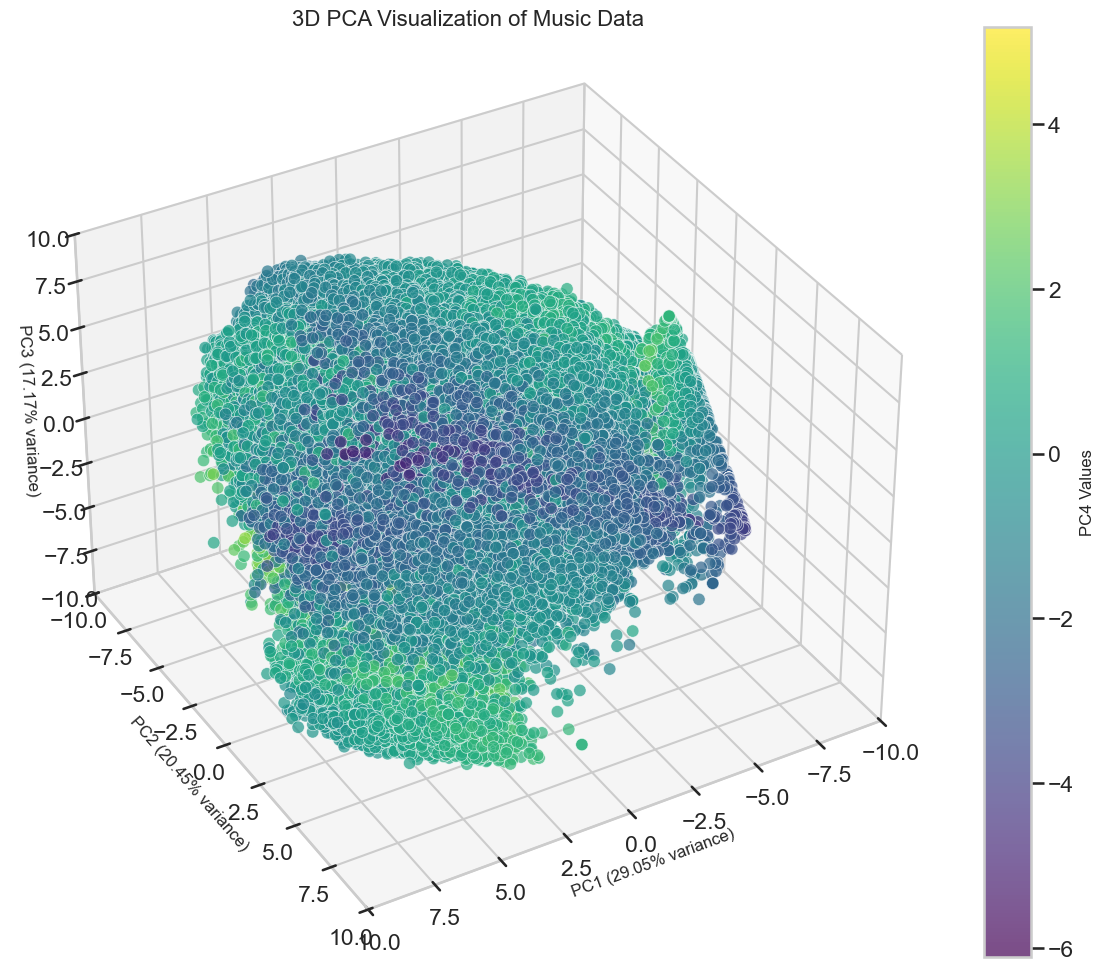

In [37]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Create a 3D plot for the first 3 principal components
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scale data for better visualization
scaler = MinMaxScaler(feature_range=(-10, 10))
viz_data = scaler.fit_transform(df_pca_improved[['PC1', 'PC2', 'PC3']])

# Create scatter plot
scatter = ax.scatter(
    viz_data[:, 0], viz_data[:, 1], viz_data[:, 2],
    c=df_pca_improved['PC4'],
    cmap='viridis', alpha=0.7, s=80, 
    edgecolors='w', linewidth=0.5
)

# Add labels and styling
plt.colorbar(scatter).set_label('PC4 Values', fontsize=12)
ax.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_variance[2]:.2%} variance)', fontsize=12)
plt.title('3D PCA Visualization of Music Data', fontsize=16)

# Set view properties
ax.grid(True, alpha=0.3)
ax.view_init(elev=35, azim=60)
ax.set_xlim(-10, 10); ax.set_ylim(-10, 10); ax.set_zlim(-10, 10)

plt.tight_layout()
plt.show()
